In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as ptl 
import seaborn as sns 
import os 
from scipy.stats import norm


## Meta info

In [ ]:
folder_path = '../metadata'

In [ ]:
folder_path = '../metadata'
# Step 1: List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Step 2: Read and concatenate all files
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    temp_df = pd.read_csv(file_path)
    df_list.append(temp_df)

# Step 3: Concatenate all DataFrames into one giant DataFrame
giant_df = pd.concat(df_list, ignore_index=True)
# Optional: Display the shape and first few rows
print(f"Shape of the giant DataFrame: {giant_df.shape}")
giant_df.head(2)

## Merge all results

In [3]:
df = pd.read_csv('../all_results.csv')
df.head(1)

,data_framework,J,R,E,M,algo,E_Num,n_partial_rankings,kendalls_tau,average_partial_ranking_length,mae
0,PL,50,0.1,Exp 10: S + Continuous kj (Skewed) + X (Normal),0,BT,10,3,0.12381,8.666667,1.28


In [4]:
set(df.algo)

{'BT', 'EBM', 'Mallows_Tau', 'PL', 'Pairwise'}

In [5]:
saebm_df = df[df['algo'] == 'EBM'].copy()
other_df = df[df['algo'] != 'EBM'].copy()

key_cols = ['data_framework', 'J', 'R', 'M', 'E_Num', 'E']
merged_df = other_df.merge(
    saebm_df[key_cols + ['kendalls_tau', 'mae', ]],  # Select metrics to include
    on=key_cols,
    how='left',
    suffixes=('', '_saebm')
)
merged_df['mae_advantage'] = merged_df['mae_saebm'] - merged_df['mae']
merged_df['tau_advantage'] = merged_df['kendalls_tau_saebm'] - merged_df['kendalls_tau']

In [6]:
merged_df.head(2)

,data_framework,J,R,E,M,algo,E_Num,n_partial_rankings,kendalls_tau,average_partial_ranking_length,mae,kendalls_tau_saebm,mae_saebm,mae_advantage,tau_advantage
0,PL,50,0.1,Exp 10: S + Continuous kj (Skewed) + X (Normal),0,BT,10,3,0.123810,8.666667,1.28,0.171429,1.00,-0.28,0.047619
1,BT,50,0.1,Exp 10: S + Continuous kj (Skewed) + X (Normal),0,BT,10,3,0.085714,8.666667,0.54,0.095238,0.76,0.22,0.009524


In [8]:
sorted(giant_df.E.unique()) == sorted(merged_df.E.unique())

True

In [9]:
final_df = merged_df.merge(
    giant_df,
    # Add 'E_Num' to the list of keys
    on=['data_framework', 'J', 'R', 'M', 'E', 'E_Num', 'algo'], 
    how='left'
)

final_df.rename(columns={'average_partial_ranking_length': 'mean_len', 'n_partial_rankings':"n_pr"}, inplace=True)
# drop rows where column 'my_column' is NaN
final_df = final_df.dropna(subset=['sharpness'])

# You will no longer have E_Num_x and E_Num_y columns, 
# and the columns from giant_df should now be populated correctly.

In [10]:
final_df.to_csv('final_df.csv', index=False)

In [11]:
final_df.sample(2)

,data_framework,J,R,E,M,algo,E_Num,n_pr,kendalls_tau,mean_len,mae,kendalls_tau_saebm,mae_saebm,mae_advantage,tau_advantage,conflict,overlap_rate,separation,sharpness,spearman_rho
22945,BT,100,0.50,Exp 9: S + Continuous kj (Skewed) + X (Sigmoid),6,BT,9,4,0.132353,9.500000,0.830,0.250000,0.990,0.16,0.117647,0.538889,0.882353,1.000000,0.963643,0.727960
33449,Mallows_Tau_T10,200,0.25,Exp 5: S + Continuous kj (Uniform) + X (Normal),3,PL,5,3,0.164835,7.333333,0.685,0.032967,0.455,-0.23,-0.131868,0.777778,0.500000,0.999085,0.650008,0.736291


In [12]:
final_df['algo'].unique()

array(['BT', 'Mallows_Tau', 'PL', 'Pairwise'], dtype=object)

# Let's do meta-analysis

In [13]:
meta_df = final_df[['data_framework', 'conflict', 'overlap_rate', 'separation', 'sharpness', 'n_pr', 'mean_len']].copy()
meta_df.head()

,data_framework,conflict,overlap_rate,separation,sharpness,n_pr,mean_len
0,PL,0.188889,0.666667,1.000000,0.861868,3,8.666667
1,BT,0.188889,0.666667,1.000000,0.975450,3,8.666667
2,Pairwise,0.188889,0.666667,1.000000,0.945837,3,8.666667
4,Mallows_Tau_T1,0.188889,0.666667,0.995907,0.473043,3,8.666667
5,Mallows_Tau_T10,0.000000,0.300000,0.999924,0.832503,2,6.500000


In [25]:
pl_df = meta_df[meta_df["data_framework"] == "PL"].copy() # 0.648
import statsmodels.api as sm

# predictors and response
X = pl_df[["n_pr","mean_len", "conflict", "overlap_rate"]]
y = pl_df["sharpness"]

# add intercept
X = sm.add_constant(X)

# fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sharpness   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     3311.
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:41:43   Log-Likelihood:                 6626.2
No. Observations:                7200   AIC:                        -1.324e+04
Df Residuals:                    7195   BIC:                        -1.321e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3317      0.012    112.251   

In [28]:
pl_df = meta_df[meta_df["data_framework"] == "BT"].copy() # 0.683
import statsmodels.api as sm

# predictors and response
X = pl_df[["n_pr","mean_len", "conflict", "overlap_rate"]]
y = pl_df["sharpness"]

# add intercept
X = sm.add_constant(X)

# fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sharpness   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     3883.
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:42:14   Log-Likelihood:                 21783.
No. Observations:                7200   AIC:                        -4.356e+04
Df Residuals:                    7195   BIC:                        -4.352e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0707      0.001    740.871   

In [29]:
from statsmodels.iolib.summary2 import summary_col

# If you have multiple models, you can pass a list
latex_table = summary_col([model], 
                          stars=True, 
                          float_format="%.3f",
                          model_names=["PL model"],
                          info_dict={'N':lambda x: f"{int(x.nobs)}",
                                     'R2':lambda x: f"{x.rsquared:.3f}",
                                     'Adj. R2':lambda x: f"{x.rsquared_adj:.3f}"}
                         ).as_latex()

print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{ll}
\hline
               & PL model   \\
\hline
const          & 1.071***   \\
               & (0.001)    \\
n\_pr          & -0.011***  \\
               & (0.000)    \\
mean\_len      & -0.005***  \\
               & (0.000)    \\
conflict       & -0.032***  \\
               & (0.001)    \\
overlap\_rate  & -0.026***  \\
               & (0.001)    \\
R-squared      & 0.683      \\
R-squared Adj. & 0.683      \\
N              & 7200       \\
R2             & 0.683      \\
Adj. R2        & 0.683      \\
\hline
\end{tabular}
\end{center}
\end{table}
\bigskip
Standard errors in parentheses. \newline 
* p<.1, ** p<.05, ***p<.01


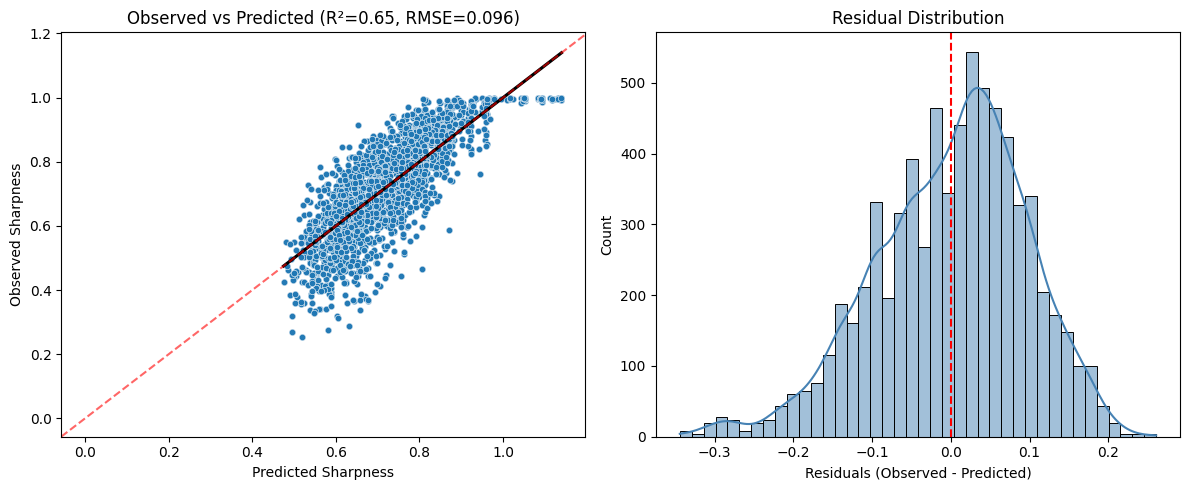

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Predictions
# y_pred = model.predict(X)
# residuals = y - y_pred
# rmse = np.sqrt(((y - y_pred)**2).mean())

# # Create figure with 2 subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # --- Panel A: Observed vs Predicted ---
# sns.scatterplot(x=y_pred, y=y, s=20, alpha=0.6, ax=axes[0])
# sns.regplot(x=y_pred, y=y, scatter=False, color="black", ax=axes[0])  # regression line
# axes[0].axline((0,0), slope=1, linestyle="--", color="red", alpha=0.6)  # y=x line
# axes[0].set_xlabel("Predicted Sharpness")
# axes[0].set_ylabel("Observed Sharpness")
# axes[0].set_title(f"Observed vs Predicted (R²={model.rsquared:.2f}, RMSE={rmse:.3f})")

# # --- Panel B: Residual Distribution ---
# sns.histplot(residuals, kde=True, bins=40, ax=axes[1], color="steelblue")
# axes[1].axvline(0, color="red", linestyle="--")
# axes[1].set_xlabel("Residuals (Observed - Predicted)")
# axes[1].set_ylabel("Count")
# axes[1].set_title("Residual Distribution")

# plt.tight_layout()
# plt.show()


In [30]:
pl_df = meta_df[meta_df["data_framework"] == "Pairwise"].copy() # 0.256
import statsmodels.api as sm

# predictors and response
X = pl_df[["n_pr","mean_len", "conflict", "overlap_rate"]]
y = pl_df["sharpness"]

# add intercept
X = sm.add_constant(X)

# fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sharpness   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     618.0
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:44:49   Log-Likelihood:                 9812.5
No. Observations:                7200   AIC:                        -1.961e+04
Df Residuals:                    7195   BIC:                        -1.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0390      0.008    136.329   

In [33]:
pl_df = meta_df[meta_df["data_framework"] == "Mallows_Tau_T1"].copy() # 0.852
import statsmodels.api as sm

# predictors and response
X = pl_df[["n_pr","mean_len", "conflict", "overlap_rate"]]
y = pl_df["sharpness"]

# add intercept
X = sm.add_constant(X)

# fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sharpness   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 1.044e+04
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:46:14   Log-Likelihood:                 15851.
No. Observations:                7200   AIC:                        -3.169e+04
Df Residuals:                    7195   BIC:                        -3.166e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0648      0.003    323.221   

In [34]:
# If you have multiple models, you can pass a list
latex_table = summary_col([model], 
                          stars=True, 
                          float_format="%.3f",
                          model_names=["PL model"],
                          info_dict={'N':lambda x: f"{int(x.nobs)}",
                                     'R2':lambda x: f"{x.rsquared:.3f}",
                                     'Adj. R2':lambda x: f"{x.rsquared_adj:.3f}"}
                         ).as_latex()

print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{ll}
\hline
               & PL model   \\
\hline
const          & 1.065***   \\
               & (0.003)    \\
n\_pr          & -0.111***  \\
               & (0.001)    \\
mean\_len      & -0.046***  \\
               & (0.000)    \\
conflict       & 0.006***   \\
               & (0.002)    \\
overlap\_rate  & 0.272***   \\
               & (0.003)    \\
R-squared      & 0.853      \\
R-squared Adj. & 0.853      \\
N              & 7200       \\
R2             & 0.853      \\
Adj. R2        & 0.853      \\
\hline
\end{tabular}
\end{center}
\end{table}
\bigskip
Standard errors in parentheses. \newline 
* p<.1, ** p<.05, ***p<.01


In [35]:
pl_df = meta_df[meta_df["data_framework"] == "Mallows_Tau_T10"].copy() # 0.861
import statsmodels.api as sm

# predictors and response
X = pl_df[["n_pr","mean_len", "conflict", "overlap_rate"]]
y = pl_df["sharpness"]

# add intercept
X = sm.add_constant(X)

# fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sharpness   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 1.122e+04
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:47:21   Log-Likelihood:                 15134.
No. Observations:                7200   AIC:                        -3.026e+04
Df Residuals:                    7195   BIC:                        -3.022e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2508      0.003    359.270   

In [36]:
# If you have multiple models, you can pass a list
latex_table = summary_col([model], 
                          stars=True, 
                          float_format="%.3f",
                          model_names=["PL model"],
                          info_dict={'N':lambda x: f"{int(x.nobs)}",
                                     'R2':lambda x: f"{x.rsquared:.3f}",
                                     'Adj. R2':lambda x: f"{x.rsquared_adj:.3f}"}
                         ).as_latex()

print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{ll}
\hline
               & PL model   \\
\hline
const          & 1.251***   \\
               & (0.003)    \\
n\_pr          & -0.122***  \\
               & (0.001)    \\
mean\_len      & -0.049***  \\
               & (0.000)    \\
conflict       & 0.005***   \\
               & (0.002)    \\
overlap\_rate  & 0.299***   \\
               & (0.004)    \\
R-squared      & 0.862      \\
R-squared Adj. & 0.862      \\
N              & 7200       \\
R2             & 0.862      \\
Adj. R2        & 0.862      \\
\hline
\end{tabular}
\end{center}
\end{table}
\bigskip
Standard errors in parentheses. \newline 
* p<.1, ** p<.05, ***p<.01


# Start modeling

In [149]:
df = final_df.copy()

In [150]:
predictors = ['n_pr', 'mean_len', 'sharpness', 'overlap_rate', 'conflict', 'separation', 'spearman_rho']

In [151]:
df[df.data_framework == 'Random']

,data_framework,J,R,E,M,algo,E_Num,n_pr,kendalls_tau,mean_len,mae,kendalls_tau_saebm,mae_saebm,mae_advantage,tau_advantage,conflict,overlap_rate,separation,sharpness,spearman_rho


In [152]:
df['data_framework'].unique()

array(['PL', 'BT', 'Pairwise', 'Mallows_Tau_T1', 'Mallows_Tau_T10'],
      dtype=object)

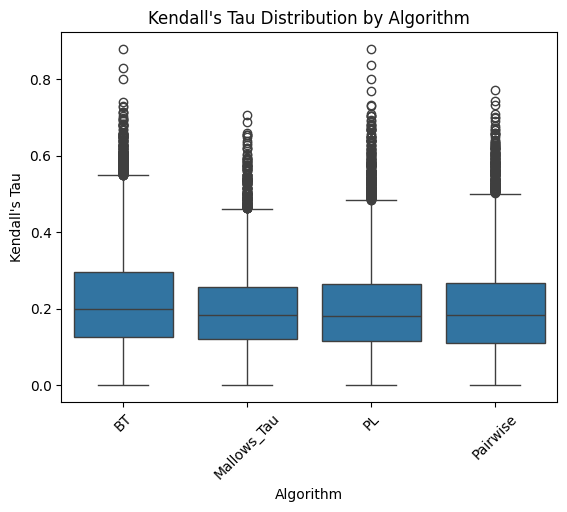

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
sns.boxplot(x='algo', y='kendalls_tau', data=final_df)
plt.title('Kendall\'s Tau Distribution by Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Kendall\'s Tau')
plt.xticks(rotation=45)
plt.show()

In [124]:
# print(df.groupby('algo')[['kendalls_tau', 'n_pr', 'mean_len', 'conflict', 'overlap_rate', 'sharpness']].agg(['mean', 'median', 'std']))

In [154]:
import statsmodels.formula.api as smf

model = smf.ols("tau_advantage ~ J + R + C(E) + spearman_rho + sharpness + overlap_rate + conflict + C(algo)", data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          tau_advantage   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     402.1
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:55:29   Log-Likelihood:                 26278.
No. Observations:               36000   AIC:                        -5.251e+04
Df Residuals:                   35979   BIC:                        -5.234e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [128]:
print(df[['n_pr','mean_len','overlap_rate','conflict', 'separation']].corr())


                  n_pr  mean_len  overlap_rate  conflict  separation
n_pr          1.000000  0.004134      0.810978 -0.005513   -0.090237
mean_len      0.004134  1.000000      0.345336  0.084706   -0.055027
overlap_rate  0.810978  0.345336      1.000000  0.041472   -0.100232
conflict     -0.005513  0.084706      0.041472  1.000000   -0.037551
separation   -0.090237 -0.055027     -0.100232 -0.037551    1.000000


In [130]:
import statsmodels.formula.api as smf

# base model with nothing
m0 = smf.ols("tau_advantage ~ 1", data=df).fit()

# add E
m1 = smf.ols("tau_advantage ~ C(E)", data=df).fit()

# add algo
m2 = smf.ols("tau_advantage ~ C(E) + C(algo)", data=df).fit()

# add sharpness
m3 = smf.ols("tau_advantage ~ C(E) + C(algo) + sharpness", data=df).fit()

# add overlap_rate
m4 = smf.ols("tau_advantage ~ C(E) + C(algo) + sharpness + overlap_rate", data=df).fit()

m5 = smf.ols("tau_advantage ~ C(E) + C(algo) + sharpness + overlap_rate + separation", data=df).fit()

print("E:", m1.rsquared - m0.rsquared)
print("algo:", m2.rsquared - m1.rsquared)
print("sharpness:", m3.rsquared - m2.rsquared)
print("overlap_rate:", m4.rsquared - m3.rsquared)
print("separation:", m5.rsquared - m4.rsquared)

E: 0.13930957994599413
algo: 0.005939786512693002
sharpness: 0.014678563030851355
overlap_rate: 0.010810089730414973
separation: 2.1883967715741193e-06
